# Delay Scan -  DESC fringes on ExitScreen

In [1]:
import h5py;
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Image

DAQ run with delay scan

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28496.h5
Delay Scan: 32 steps ?


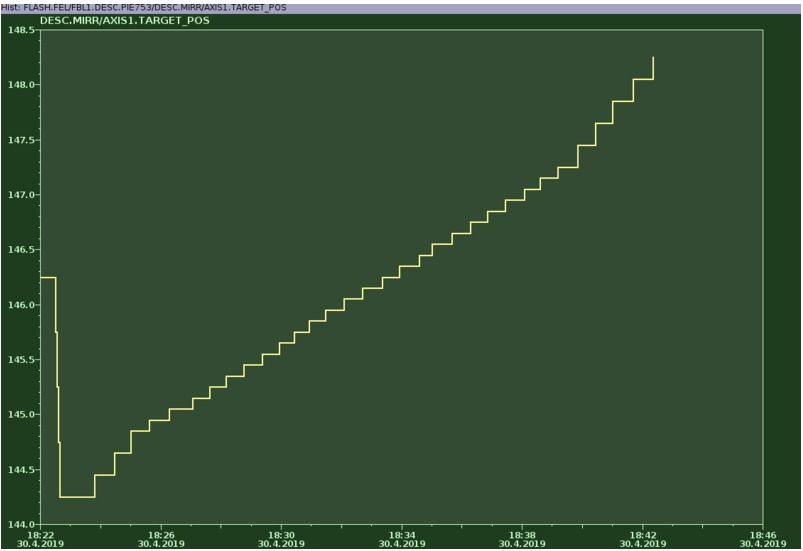

In [2]:
runNumber = 28496

dataDir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdfFilename = 'FLASH1_USER1-run'+str(runNumber)+'.h5'
imagePath = '/asap3/flash/gpfs/bl1/2017/data/11003895/processed/notebooks/fig/'

print(dataDir+hdfFilename)
print('Delay Scan: 32 steps ?')
Image("delaymotor_history.jpeg")

### Read motor position

<class 'numpy.ndarray'> | (13200, 1)


/software/anaconda3/5.2/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


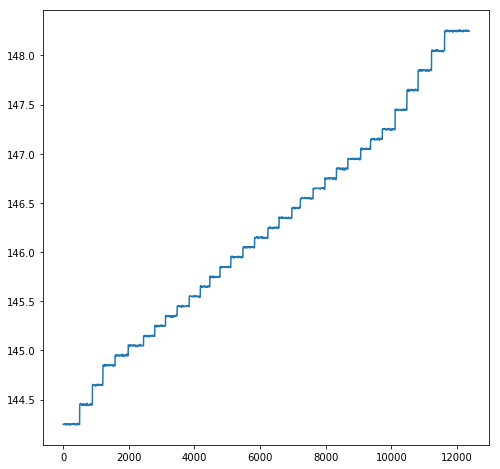

In [3]:
hdfFile = h5py.File(dataDir+hdfFilename,'r')
motorPos = hdfFile['/FL1/Experiment/BL1/CAMP/DESC/Fine delay stage/position'].value
print(type(motorPos),'|', motorPos.shape)
plt.figure(figsize=(8,8))
plt.plot(motorPos)

### Check Motor Position for NaNs

Number of NaNs: 831


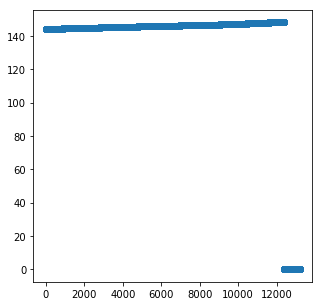

In [4]:
motorPosWoNaN = np.nan_to_num(motorPos)
plt.figure(figsize=(5,5))
plt.plot(motorPosWoNaN,'o')

NoNans = (motorPosWoNaN>1)
res2 = [i for i, val in enumerate(NoNans) if val]
print('Number of NaNs:',len(motorPos)-len(res2))

### Read Images from h5 file 

In [5]:
hdfFile = h5py.File(dataDir+hdfFilename,'r')
img = hdfFile['/uncategorised/FLASH1_USER1/FLASH.FEL/FBL1.CAM/EXIT_SCREEN/dset'].value
print(type(img),'|',img.shape)

<class 'numpy.ndarray'> | (13200, 1280, 960)


/software/anaconda3/5.2/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


### Define ROI & Calculate Integral of ROI for all Images

In [6]:
ROI_x1, ROI_y1 = 200, 100
ROI_x2, ROI_y2 = 700, 700

integral = np.asarray([np.sum(img[index][ROI_x1:ROI_x2,ROI_y1:ROI_y2]) for index in range(0,img.shape[0])])

### Plot Blank Images & Delay Steps

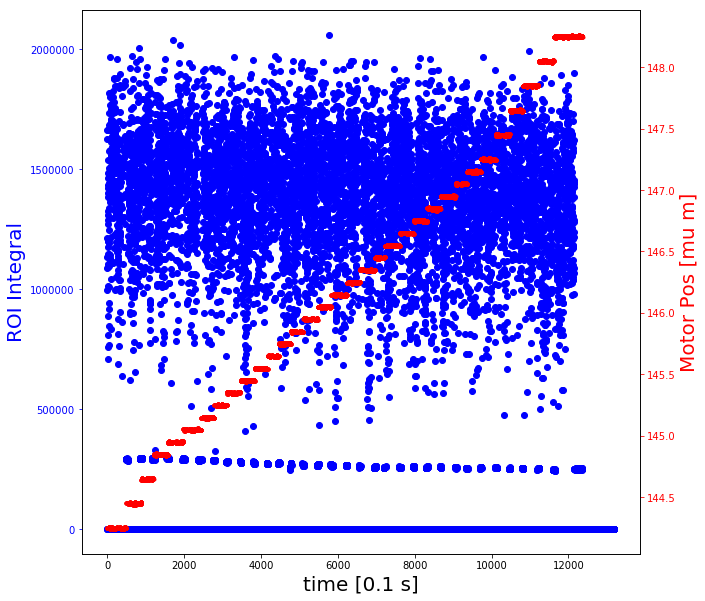

In [7]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(integral,'bo')
ax1.set_xlabel('time [0.1 s]',fontsize=20)
ax1.set_ylabel('ROI Integral', color='b', fontsize=20)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(motorPos,'r.')
ax2.set_ylabel('Motor Pos [mu m]', color='r', fontsize=20)
ax2.tick_params('y', colors='r')

plt.show()

* We see that we have 3 types of images: real images (fringes), dark images (blocked shutter) & zeros (DAQ drops)
* 33 delay steps 
* drift in darks? 

### Zooming In

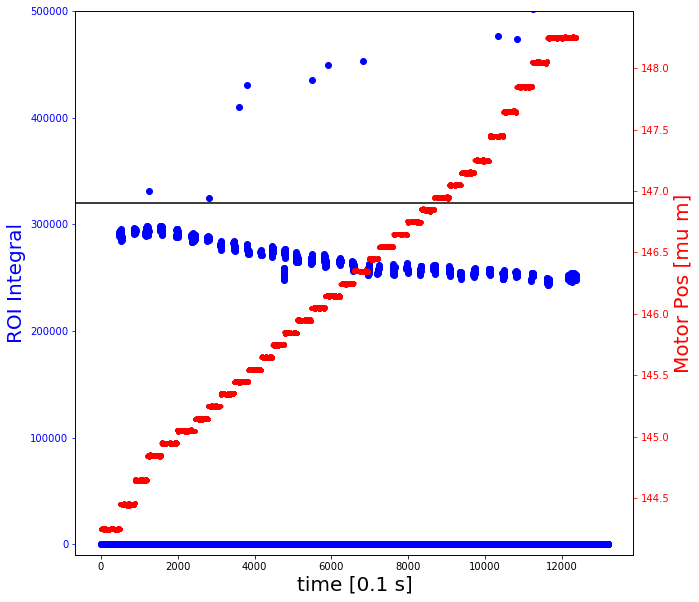

In [8]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(integral,'bo')
ax1.set_xlabel('time [0.1 s]',fontsize=20)
ax1.set_ylabel('ROI Integral', color='b', fontsize=20)
ax1.tick_params('y', colors='b')
ax1.set_ylim(-10000,500000)

plt.axhline(y=320000, color='k')

ax2 = ax1.twinx()
ax2.plot(motorPos,'r.')
ax2.set_ylabel('Motor Pos [mu m]', color='r', fontsize=20)
ax2.tick_params('y', colors='r')

plt.show()

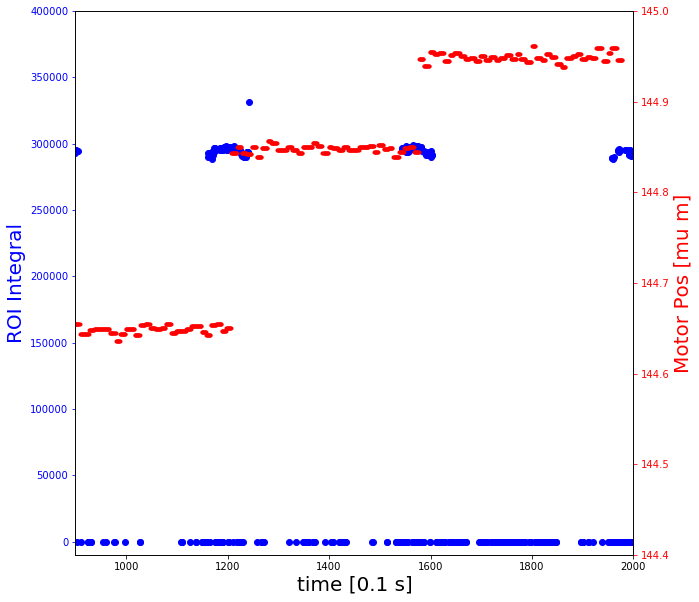

In [9]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(integral,'bo')
ax1.set_xlabel('time [0.1 s]',fontsize=20)
ax1.set_ylabel('ROI Integral', color='b', fontsize=20)
ax1.tick_params('y', colors='b')

ax1.set_ylim(-10000,400000)
ax1.set_xlim(900,2000)

ax2 = ax1.twinx()
ax2.plot(motorPos,'r.')
ax2.set_ylabel('Motor Pos [mu m]', color='r', fontsize=20)
ax2.tick_params('y', colors='r')

ax2.set_ylim(144.4,145)

plt.show()

In [10]:
logicMap = (integral>1000)
res = [i for i, val in enumerate(logicMap) if val]
print('Number of blanks in the end:', len(logicMap)-res[-1])
print('Acutal Rate in dataset (without appended blanks): % .3f '%(len(res)/res[-1]))

Number of blanks in the end: 833
Acutal Rate in dataset (without appended blanks):  0.729 


### Define Delay Steps

Number of Delay Stage Steps:  33
[498, 887, 1206, 1577, 1978, 2445, 2787, 3115, 3468, 3837, 4176, 4466, 4776, 5105, 5475, 5830, 6235, 6576, 6965, 7225, 7613, 7974, 8324, 8673, 9064, 9364, 9722, 10113, 10472, 10813, 11222, 11620]


/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


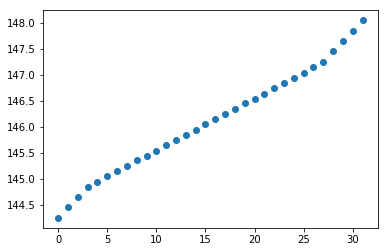

In [11]:
motorMovTreshold = 0.03

resMov = np.asarray([x -y for x,y in zip(motorPos, motorPos[1:])])
resMov = np.append(resMov,0)
changeMotorPos = ( np.abs(resMov) > motorMovTreshold)
print('Number of Delay Stage Steps: ',np.count_nonzero(changeMotorPos) +1 )

indexMotorChange = [i for i, val in enumerate(changeMotorPos) if val] 
print(indexMotorChange)

plt.plot(motorPos[changeMotorPos],'o')
plt.show()

# testing - example

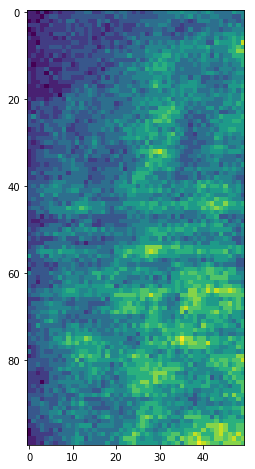

In [12]:
test_img=img[1300][400:500, 250:300]

plt.figure(figsize=(16,8))
plt.imshow(test_img)

In [13]:
def extractProfileLine(integrateImage):
    startSum = int(integrateImage.shape[1]/2)-20
    endSum = int(integrateImage.shape[1]/2)+20
    return np.sum(integrateImage[:,startSum:endSum], axis=1)

def calcVisibility(profileLine):
    maxs = np.max(profileLine)
    mins = np.min(profileLine)
    return (maxs-mins)/(maxs+mins)

/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in ulong_scalars
  if __name__ == '__main__':


number of profile lines: 498


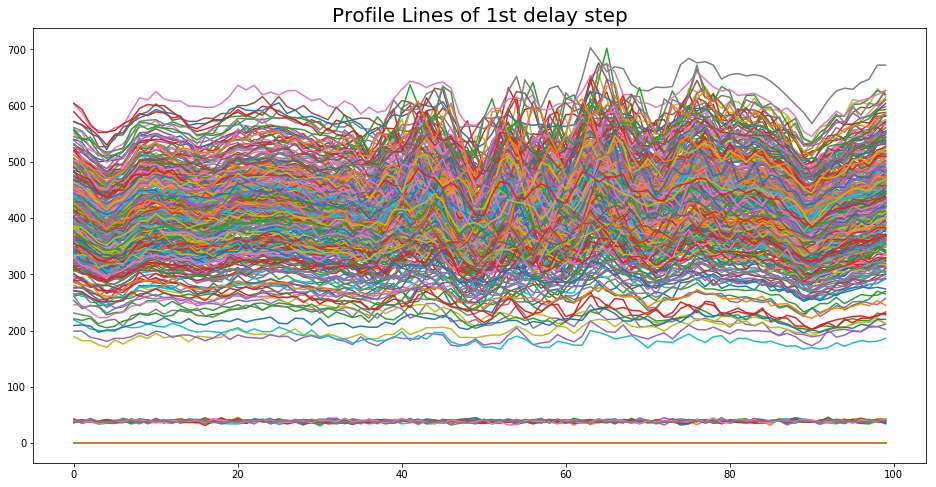

In [14]:
profileLines_test = np.asarray([extractProfileLine(img[index][400:500, 250:300]) for index in range(0,498)])
visibilities_test = np.asarray([calcVisibility(profileLines_test[index]) for index in range(0,profileLines_test.shape[0])])

print('number of profile lines:',len(profileLines_test))

plt.figure(figsize=(16,8))
[plt.plot(profileLines_test[index]) for index in range(0,profileLines_test.shape[0])]
plt.title('Profile Lines of 1st delay step', fontsize = 20);

### again 3 Types of profile lines: empty, dark & "lit" images

## extract visibility of scan

In [15]:
def extractVisivilityofScan(firstImage, lastImage):
    profileLines = np.asarray([extractProfileLine(img[index][400:500, 250:300]) for index in range(firstImage, lastImage)])
    visibilities = np.asarray([calcVisibility(profileLines[index]) for index in range(0,profileLines.shape[0])])
    return visibilities

In [16]:
visibilities = extractVisivilityofScan(0, img.shape[0])
print(visibilities)
print(len(visibilities))

/software/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in ulong_scalars
  if __name__ == '__main__':


[nan nan nan ... nan nan nan]
13200


In [17]:
print(img.shape)
logicMapLight = (integral>5000) # also eliminate images with closed shutter
print(logicMapLight.shape)

(13200, 1280, 960)
(13200,)


## Plot all Visibilities of Scan
* remove all images below treshold
* plot against small delaystage encoder -> jitter include

### calculate averages per delay step

In [18]:
delaysteps = np.split(visibilities,indexMotorChange)
averages = [np.nanmean(delaysteps[index]) for index in range(0,len(delaysteps))]
std = [np.nanstd(delaysteps[index]) for index in range(0,len(delaysteps))]
motorPosForAverage = np.append(motorPos[changeMotorPos], motorPos[-1000])

### Plot all values (blue) and average (red)

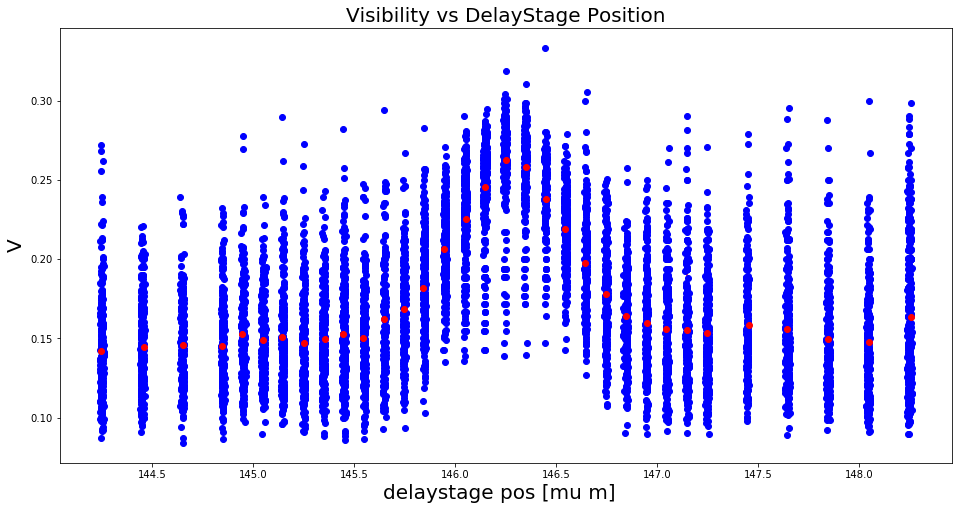

In [19]:
plt.figure(figsize=(16,8))
[plt.plot(motorPos[index],visibilities[index],'bo') for index in range(0,len(visibilities)) if logicMapLight[index] == True]
plt.errorbar(motorPosForAverage,averages, yerr = std, fmt='o', color='r')
plt.title('Visibility vs DelayStage Position', fontsize = 20)
plt.xlabel('delaystage pos [mu m]  ',fontsize=20)
plt.ylabel('V', fontsize=20);

### Plot average with standard error (1x sigma)

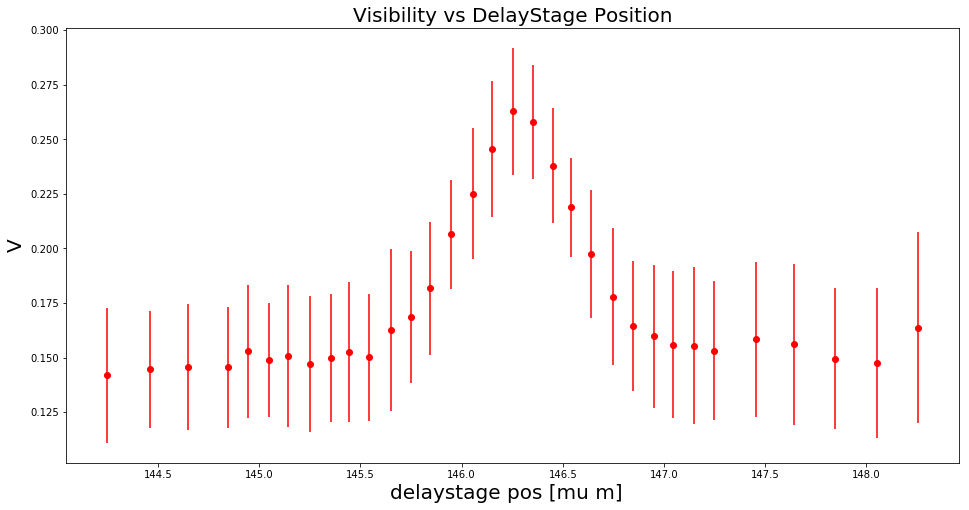

In [20]:
plt.figure(figsize=(16,8))
plt.errorbar(motorPosForAverage,averages, yerr = std, fmt='o', color='r')
plt.title('Visibility vs DelayStage Position', fontsize = 20)
plt.xlabel('delaystage pos [mu m]  ',fontsize=20)
plt.ylabel('V', fontsize=20);